#Classes to be implemented


*   TheWorld [DONE]
*   User [DONE]
*   AI_Assistant
    *   Environment
    *   Planner [WIP]
    *   UserModel [WIP]





## Easy Navigation
* [Obj dev area](#dev)
* [Code testing area](#testing)
* [Tutorial starts here](#start)
    * [Initialization](#init)
    * [Task 1: Implement user model](#task1)
    <!--     * [Task 1 part i](#task_11)
        * [Task 1 part ii](#task_12)
        * [Task 1 part iii](#task_13) -->
    * [Task 2: Implement param inference](#task2)
    <!--     * [Case study i: "all coins display tails"](#task_21)
        * [Case study ii: at least "1 coin display tails" ](#task_22)
        * [(Bonus) Case study iii: "Exactly 1 tail"  ](#task_23) -->
    * [Task 3: Implement interaction loop](#task3)
    <!--     * [Task 3 part i](#task_31)
        * [(Optional) Task 3 part ii](#task_32)
        * [Task 3 part iii](#task_33)
            * [Plot by mean/SD value](#task_33_abs)
            * [Plot by RMSE](#task_33_rmse) -->

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import bernoulli, multivariate_normal
from scipy.optimize import minimize
import copy
from tutorialObjs import World, User, Route

# Agent class (WIP) <a class="anchor" id="dev"></a>

In [9]:
class Assistant:
    # MLE infer user params
    # plan assuming MLE
    # delta-dirac
    # analytical closed form posterior of the current user param estimate
    # return param sample
    def __init__(self):
        self.user_model = None
        self.planner = None
        self.env = None
        self.observations = []

    def take_action(self):
        best_action = self.planner.recommend(self.env, self.user_model)
        return best_action

    def observe(self, obs):
        self.observations.append(obs)
        if self.env is None:
            self.env = Env(obs) #,self.user_model)
        self.user_model.update(obs)
        self.env.update(obs)
        self._update(obs)

    def _update(self, obs):
        pass

In [10]:
class Planner:
    def __init__(self):
        pass

    def _plan(self):
        pass

    def _select_best(self):
        pass

    def recommend(self,env,user_model):
        param_sample = user_model.sample()
        all_actions = env.getPossibleActions()
        action = self._select_best(all_actions)
        return action

In [97]:
class Env:
    def __init__(self,world_state,user_model):
        self.world = world_state
        self.user_model = user_model
        self.start = world_state.start
        self.destination = world_state.destination
        self.bin_edges = np.array(world_state.bin_edges)
        self._find_valid_paths()

    def _find_valid_paths(self):
        self.all_roads = list(nx.all_simple_paths(self.world.graph, 
                                                  source=self.start, 
                                                  target=self.destination))
        
        # Generate modes for known task connections
        self.modes_dict = dict()
        self.path_tuples = []
        for road in self.all_roads:
            cur_path = []
            for segment in range(len(road)-1):
                c_begin, c_end = road[segment], road[segment+1]
                cur_path.append((c_begin, c_end))
                if (c_begin,c_end) not in self.modes_dict.keys():
                    # which mode is available?
                    modes_list = world.bin_edges[c_begin][c_end]
                    mode_mask = ['1' in mode for mode in modes_list]
                    mode_ind = [i for i,x in enumerate(mode_mask) if x]
                    self.modes_dict[(c_begin,c_end)] = mode_ind
            self.path_tuples.append(cur_path)
                
    
    # def step(self, action):
    #     pass

    def update(self, obs):
        # infer new params based on obs
        # step 1: find difference + calculate cost difference (also consider choice?)
        pass

    def getCurrentPlayer(self):
        return 1

    def getPossibleActions(self):
        actions = []
        for route in self.path_tuples:
            route_options = []
            for segment in route:
                modes = self.modes_dict[segment]
                for mode in modes:
                    route_options.append()



    def takeAction(self, action):
        raise NotImplementedError()

    def isTerminal(self):
        return self.init_state.path_ai == self.init_state.path_user
        

    def getReward(self):
        # only needed for terminal states
        raise NotImplementedError()

    def __eq__(self, other):
        raise NotImplementedError()

In [51]:
class UserModel(User):
    # implement user cross over
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
        mu = self.user_params
        cov = np.eye(3)
        self.param_dist = multivariate_normal(mean=mu,cov=cov)
        

    def update(self, obs):
        if obs.path_ai != obs.path_user:
            # step 1: check what user changed
            ai_advice = [s.get_itinerary() for s in obs.path_ai]
            changes = [s for s in obs.path_user if s.get_itinerary() not in ai_advice]
            for c in changes:
                cost_vec = c.get_costs()

                # step 2: Use Laplace Approx for posterior
                # Debug idea: change init value every time
                init_mean = self.param_dist.mean
                optim = minimize(self._log_posterior, init_mean, args=(cost_vec,), method='BFGS')
                if not optim.success:
                    print("Failed to minimize")
                w_map = optim.x/np.sum(optim.x)
                hessian = np.linalg.inv(optim.hess_inv)

#                 print(w_map,np.any(hessian<0))
                self.param_dist = multivariate_normal(mean=w_map,
                                                      cov=np.abs(hessian))

    def _log_posterior(self,w,a):
        w_mu = self.param_dist.mean
        w_cov = self.param_dist.cov
#         log_prior = (w - w_mu).dot(np.linalg.inv(w_cov)).dot(w - w_mu)
        log_prior = self.param_dist.logpdf(w)
        log_likelihood = w.dot(a) 
        return -1*(log_prior + log_likelihood)
    
    def sample(self):
        return self.param_dist.rvs(size=self.user_params.shape)

## Testing area <a class="anchor" id="testing"></a>

In [28]:
np.random.seed(12345)

N_CITIES = 10
N_MODES = 5

modes_prob = 0.6    # prob of each edge to be existed
modes_cost = [(2*i+1, 1) for i in range(N_MODES)]     # The higher the mode index, more expensive and faster. ## cost = mu + |e| where e~N(0,1) ##
modes_time = [(10*(N_MODES-i), 5) for i in range(N_MODES)]
modes_dist = [(1, 0.2) for i in range(N_MODES)] # same for all for now



world = World(N_CITIES, N_MODES, modes_prob, modes_cost, modes_time, modes_dist)

ai_advice = [(7, 0, 2), (0, 3, 0), (3, 2, 1), (2, 1, 3), (1, 5, 4)]
world.step(ai_advice=ai_advice)

<Figure size 700x600 with 0 Axes>

In [52]:
true_b = np.array([1,1,1])/3
b_0 = np.array([.1,.05,.8]) # Debug idea: try different prior vector
truehuman = User(user_param=true_b)
simUser = UserModel(user_param=b_0/np.sum(b_0))

truehuman.observe(world)
simUser.observe(world)

human_action = truehuman.take_action()
world.step(user_action=human_action)

# Debug idea: try different human actions, not just one?
for i in range(5):
#     print(np.linalg.norm(true_b-simUser.param_dist.mean))
#     print(simUser.param_dist.cov)
    simUser.update(world)
#     if i % 10 == 0:
    print("New mean: ", simUser.param_dist.mean)
    print("Pr(true param): ", np.exp(simUser.param_dist.logpdf(true_b)))
    # loglik of true
    print("=====================")
    

New mean:  [0.08078803 0.71832368 0.20088829]
Pr(true param):  0.05660913752978497
New mean:  [0.07906798 0.76510661 0.15582541]
Pr(true param):  0.05512732732006618
New mean:  [0.07894711 0.76839436 0.15265853]
Pr(true param):  0.05501592634132626
New mean:  [0.07893867 0.76862536 0.15243596]
Pr(true param):  0.055008063717241436
New mean:  [0.07893809 0.76864158 0.15242033]
Pr(true param):  0.05500751366135021


# Tutorial starts here <a class="anchor" id="start"></a>

When doing research with Machine Learning, it's helpful to be able to separate the problems that have been solved from the problems you will need to solve for yourself. In our goal to help other researchers leverage the AI-assistance framework for their own research problems, we're developing this tutorial as a quick, hands-on introduction to the problem landscape. 

Due to the intorductory nature of this tutorial, we will make use of existing solutions without too much explanation of their details. Instead, we focus on guiding you through implementing the key components of the framework you would need to specify according to your research problem.

# Task details

Our task is a multi-objective optimization: an anonymous user wants to travel from city A to city B via a personalized journey itinerary catering to their travel preferences. Given that the AI assistant has never encountered this user before, how should it learn the optimal personalized recommendations for the user?


## Defining the world <a class="anchor" id="init"></a>

Consider there are 10 locations involved, 2 are accounted for based on where the journey would begin and end, then 8 are possible layover or transition locations situated in between. We arbitrarily define the start location to be number 7 and the end location to be 5. (In the plots below, these two nodes will have a darkened center for ease of visual inspection.)

Each of the 10 locations could be connected to others via several different transportation modes (e.g. train, ferry, plane, bus). Here, we'll let there be 5 different transportation mode, each represented by a graph $G_i=(V, E_i)$ where V are the cities and $E_i$ shows the connections for transportation mode $i$. The cell below visualizes these graphs. 

Different modes of transport may incur different costs. Taking a flight along edge $E_i$ may be more expensive than taking the bus, but the journey duration and travel distance may be smaller. So, we give our edges 3 properties which will be accumulated by traveling along that edge: distance, price, and time. So as to not crowd our plot, we leave these properties out. But they will be accessible properties of each edge.

<Figure size 700x600 with 0 Axes>

Starting point: 7
Destination: 5


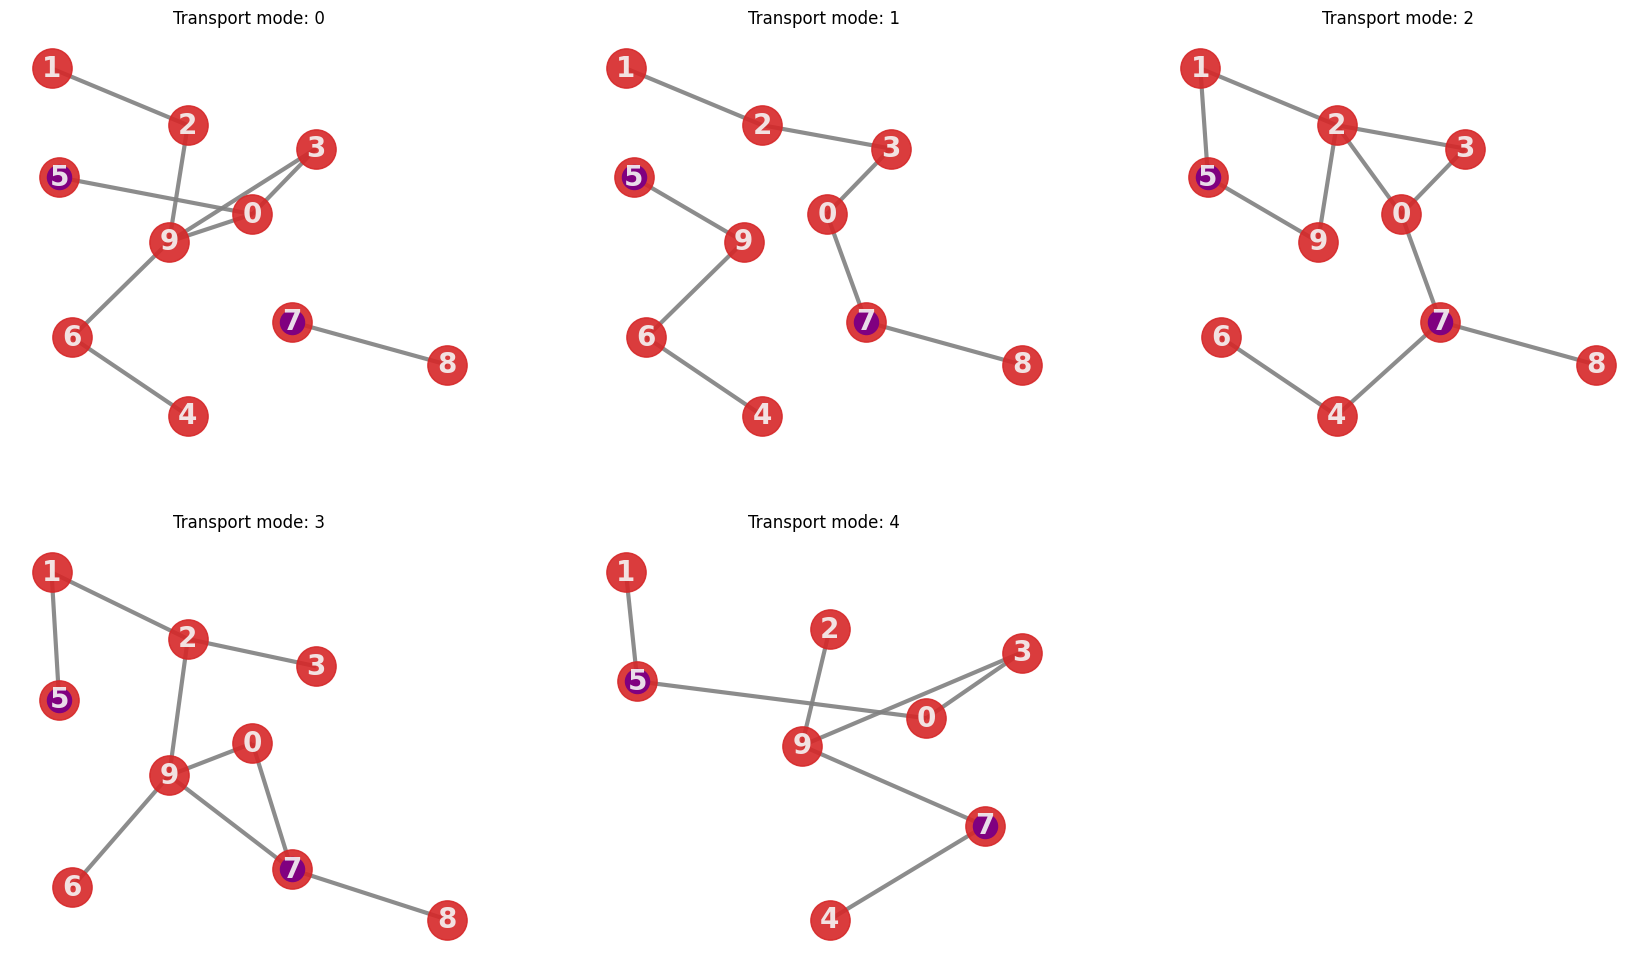

In [3]:
np.random.seed(12345)

N_CITIES = 10
N_MODES = 5

modes_prob = 0.6    # prob of each edge to be existed
modes_cost = [(2*i+1, 1) for i in range(N_MODES)]     # The higher the mode index, more expensive and faster. ## cost = mu + |e| where e~N(0,1) ##
modes_time = [(10*(N_MODES-i), 5) for i in range(N_MODES)]
modes_dist = [(1, 0.2) for i in range(N_MODES)] # same for all for now



world = World(N_CITIES, N_MODES, modes_prob, modes_cost, modes_time, modes_dist)
print("Starting point:", world.start)
print("Destination:", world.destination)
#for i in range(world.n_cities):
    #print(world.edges[i])
# world.display()

## Defining the user 

Next, we consider the anonymous user who will have hidden preferences for how they weight the tradeoff among the available transportation modes for each $E_i$ of their journey. We will denote this tradeoff by the user parameter vector $\mathbf{\beta}^*$. The costs associated with each segment of the journey will play into the user's overall preference for any given journey, so you can interpret $\mathbf{\beta}^*$ as weight parameters on the edge properties. 

Namely, for edge $e_{ij} = (d_{ij},p_{ij},t_{ij}) \in E_i$ with distance $d_{ij}$, price $p_{ij}$, and time $t_{ij}$, the user will weigh their preference as a linear combination:

$$
{\mathbf{\beta}^*}^{\intercal} e_{ij} = \beta_0 d_{ij} + \beta_1 p_{ij} + \beta_2 t_{ij}
$$

We've already implemented a computationally rational user for you. This user simulates human's limited cognitive ability to process all available options at once. Here, due to the sheer number of available options, the user is unable to identify which journey from location 7 to 5 would be their most preferred. However, when presented with a limited subset of options, the user will have a strong preference based on the hidden $\mathbf{\beta}^*$.

To illustrate this, consider the world state below. The blue path denotes the journey path suggested by the AI-assistance, while the green path denotes the user's counter proposal based on hidden preferences. The cognitive limitation illustrated here is that the human cannot and will not just arbitrarily counter-propose any possible (valid) journey path available in the defined world. Rahter, the user can only make limited improvements based on the realm of possibilities closest to the AI's original suggestion. 

(The implementation details are not necessary to know for this tutorial, but if you feel you need to reference the details of our implementation, the relevant code can be found in the `self._find_alternatives()` method of the `User` object in `tutorialObjs.py`)

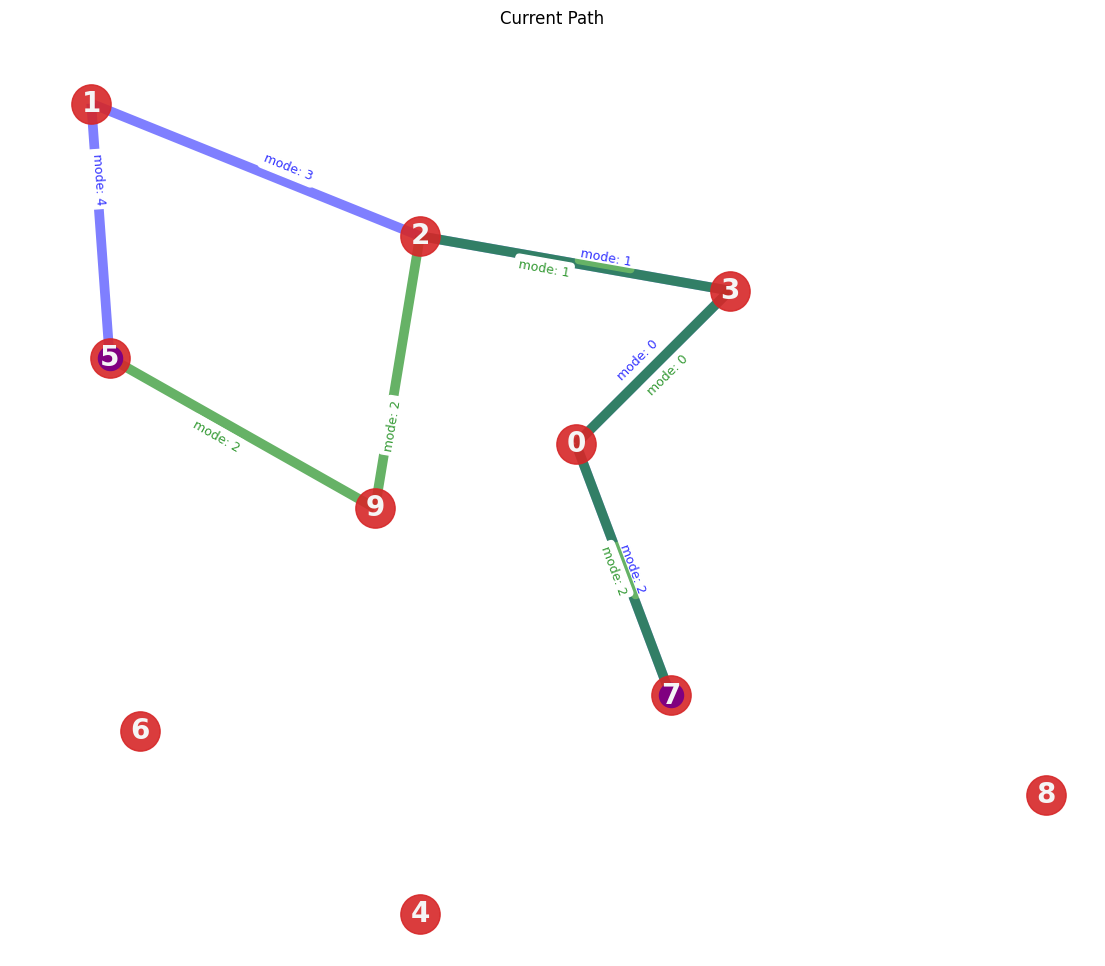

In [56]:
# AI makes a recommendation
ai_advice = [(7, 0, 2), (0, 3, 0), (3, 2, 1), (2, 1, 3), (1, 5, 4)]
world.step(ai_advice=ai_advice)

# User responds with a counter proposal based on hidden preferences
user_action = [(7, 0, 2), (0, 3, 0), (3, 2, 1), (2, 9, 2), (9, 5, 2)]
world.step(user_action=user_action)
world.display_path()

In [ ]:
user = User()

## Defining the AI 

## Task 1: Implement the user model <a class="anchor" id="task1"></a>

In [ ]:
# Give defined env
# predefined: planner,
# need: task, interaction/loop, user model, inference (implement based on equation)

## Task 2: Implement the user inference <a class="anchor" id="task2"></a>

## Task 3: Implement the AI-user interaction <a class="anchor" id="task3"></a>

The aim of the sequential interaction is to build a path between given starting point and destination and defining a mode of transfer for each route in it.

### AI's advice example

In [18]:
ai_advice = [(7, 0, 2), (0, 3, 0), (3, 2, 1), (2, 1, 3), (1, 5, 4)]
world.step(ai_advice=ai_advice)

### User's action example

In [13]:
user_action = [(7, 0, 2), (0, 3, 0), (3, 2, 1), (2, 9, 2), (9, 5, 2)]
world.step(user_action=user_action)

### Displaying the current path

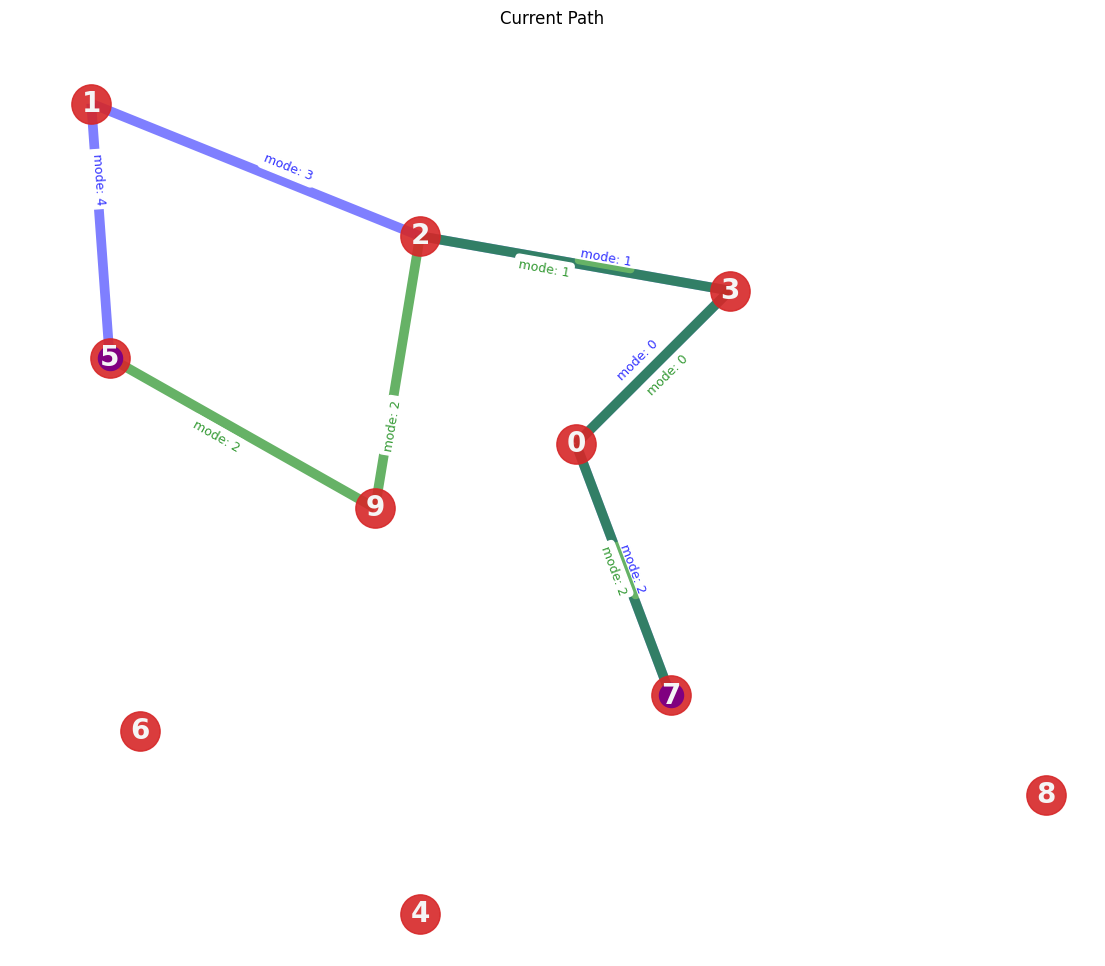

In [56]:
# AI makes a recommendation
ai_advice = [(7, 0, 2), (0, 3, 0), (3, 2, 1), (2, 1, 3), (1, 5, 4)]
world.step(ai_advice=ai_advice)

# User responds with a counter proposal based on hidden preferences
user_action = [(7, 0, 2), (0, 3, 0), (3, 2, 1), (2, 9, 2), (9, 5, 2)]
world.step(user_action=user_action)
world.display_path()

In [15]:
# In our simplification, human is just a specific instance of a user model
# initiated with a stable/consistent param.
human = UserModel(user_param=np.array([.2,.2,.2]))
# human = User()
human.observe(world)
human.user_policy(ai_advice)

([[(7, 0, 2), (0, 3, 0), (3, 2, 1), (2, 1, 3), (1, 5, 2)],
  [(7, 0, 2), (0, 3, 0), (3, 2, 1), (2, 1, 3), (1, 5, 3)],
  [(7, 0, 2), (0, 3, 0), (3, 2, 1), (2, 1, 3), (1, 5, 4)]],
 array([9.83121887e-01, 1.64096278e-02, 4.68484866e-04]))

In [ ]:
user_action = human.take_action()

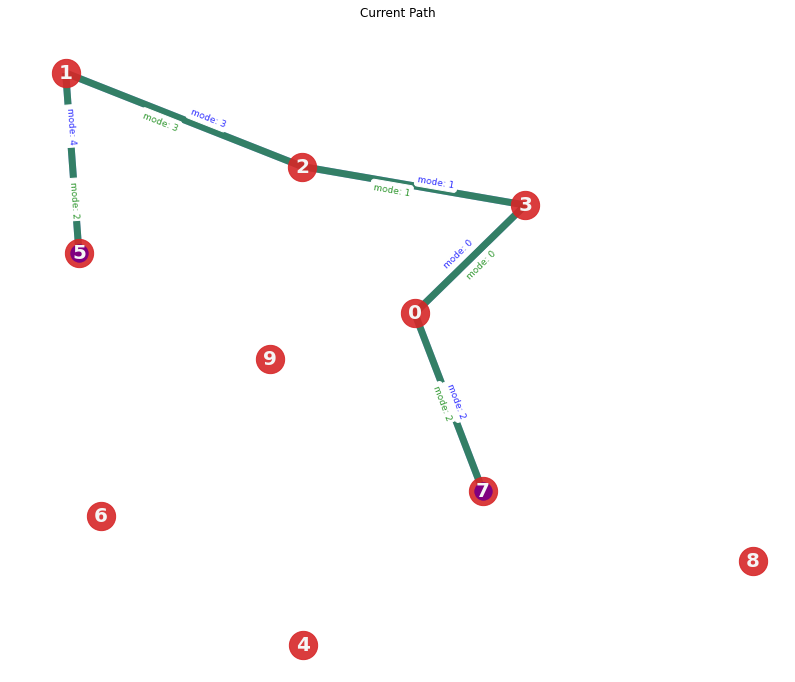

In [ ]:
world.step(user_action=user_action)
world.display_path()

AI assistant

In [ ]:
AI = Assistant()
AI.observe(world)